# Modelling

Five different supervised learning classification models are assessed to understand how well they could predict energy efficiency. Linear regression is selected as the baseline and the variance score (R2) as the quality measure used to assess the models. The other four algorithms are random forest, ada boost, XGBoost and a neural network.

This script prepares the data for modelling and can be used to run random forest, ada boost and XGBoost.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# set variables from config file
config_path = os.path.abspath('..')[:-7]

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_ex_fname = config['DEFAULT']['epc_train_ex_fname']
epc_test_ex_fname = config['DEFAULT']['epc_test_ex_fname']
epc_train_do_fname = config['DEFAULT']['epc_train_domain_fname']
epc_test_do_fname = config['DEFAULT']['epc_test_domain_fname']
epc_train_dd_fname = config['DEFAULT']['epc_train_dd_fname']
epc_test_dd_fname = config['DEFAULT']['epc_test_dd_fname']
urban_rural_fname = config['DEFAULT']['urban_rural_fname']

In [3]:
epc_train_ex = pd.read_csv(os.path.join(processing_path,epc_train_ex_fname),header = 0,delimiter = ',')
epc_test_ex = pd.read_csv(os.path.join(processing_path,epc_test_ex_fname),header = 0,delimiter = ',')
epc_train_do = pd.read_csv(os.path.join(processing_path,epc_train_do_fname),header = 0,delimiter = ',')
epc_test_do = pd.read_csv(os.path.join(processing_path,epc_test_do_fname),header = 0,delimiter = ',')
epc_train_dd = pd.read_csv(os.path.join(processing_path,epc_train_dd_fname),header = 0,delimiter = ',')
epc_test_dd = pd.read_csv(os.path.join(processing_path,epc_test_dd_fname),header = 0,delimiter = ',')

Text(0.5, 0, 'epc_test_data_driven')

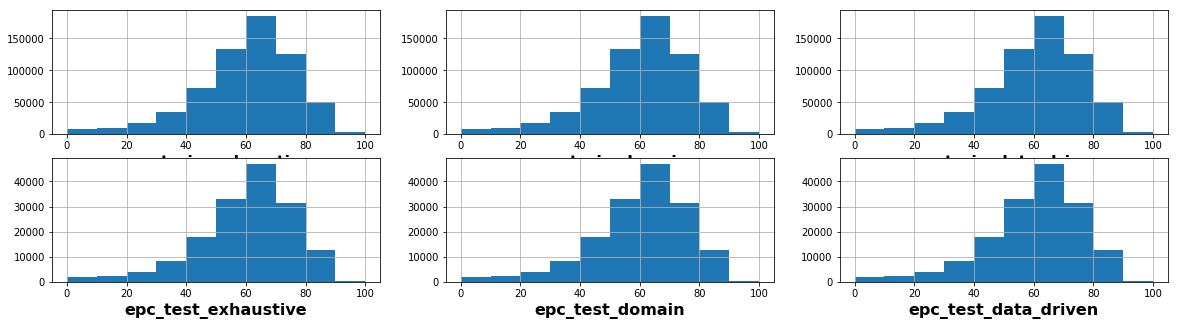

In [4]:
# plot distribution for each feature set
plt.figure(figsize=(20,5))

plt.subplot(231)
epc_train_ex['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_exhaustive',fontsize=16, weight='bold')

plt.subplot(232)
epc_train_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_domain',fontsize=16, weight='bold')

plt.subplot(233)
epc_train_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_train_data_driven',fontsize=16, weight='bold')

plt.subplot(234)
epc_test_ex['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_exhaustive',fontsize=16, weight='bold')

plt.subplot(235)
epc_test_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_domain',fontsize=16, weight='bold')

plt.subplot(236)
epc_test_do['CURRENT_ENERGY_EFFICIENCY'].hist()
plt.xlabel('epc_test_data_driven',fontsize=16, weight='bold')

### process data for selected feature set

In [5]:
def process_data_for_modelling(training_data,test_data):
    
    ''' 
    Prepares the data for modelling by one hot encoding the categorical features, converting discrete values into
    strings and dropping BUILDING_REFERENCE_NUMBER
    Parameters
      training_data: a dataframe of training data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
      test_data: a dataframe of test data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
    Returns two dataframes 
    '''
    
    training_data['mode'] = 'train'
    test_data['mode'] = 'test'
    epc = pd.concat([training_data, test_data])
    epc = epc.reset_index(drop = True)
    
    try:
        epc.drop(['LODGEMENT_DATE'],axis=1,inplace=True)
    except:
        pass
    
    try:
    epc['EXTENSION_COUNT'] = epc['EXTENSION_COUNT'].astype('str')
    epc['NUMBER_OPEN_FIREPLACES'] = epc['NUMBER_OPEN_FIREPLACES'].astype('str')
    except:
        pass
    
    for col in epc.dtypes[epc.dtypes == 'object'].index:
        if col not in ['mode']:
            print(col)
            for_dummy = epc.pop(col)
            epc = pd.concat([epc, pd.get_dummies(for_dummy, prefix=col)], axis=1)
        
    features_to_drop = ['BUILDING_REFERENCE_NUMBER']
    epc.drop(features_to_drop,axis=1,inplace=True)
    
    #Split back into train and test
    training_data = epc[epc['mode']=='train']
    test_data = epc[epc['mode']=='test']
    test_data = test_data.reset_index(drop=True)
    inputs_train = training_data.drop('mode',axis=1)
    inputs_test = test_data.drop('mode',axis=1)
    
    return inputs_train, inputs_test

In [6]:
inputs_train, inputs_test = process_data_for_modelling(epc_train_ex, epc_test_ex)

region
PROPERTY_TYPE
BUILT_FORM
TRANSACTION_TYPE
ENERGY_TARIFF
MAINS_GAS_FLAG
FLOOR_LEVEL
MAIN_HEATING_CONTROLS
GLAZED_TYPE
EXTENSION_COUNT
NUMBER_OPEN_FIREPLACES
HOTWATER_DESCRIPTION
FLOOR_DESCRIPTION
WINDOWS_DESCRIPTION
WALLS_DESCRIPTION
ROOF_DESCRIPTION
HEAT_LOSS_CORRIDOOR
LIGHTING_DESCRIPTION


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
def scale_numeric(df,col):
    
    ''' 
    Fits a scaler called scaler to the specified column
    Parameters
      df: a dataframe
      col: numeric variable to scale
    Returns a dataframe
    '''
    
    null_index = df[col].isnull()
    df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
    
    return df

In [9]:
inputs_train = scale_numeric(inputs_train,'TOTAL_FLOOR_AREA')
inputs_test = scale_numeric(inputs_test,'TOTAL_FLOOR_AREA')
try:
    inputs_train = scale_numeric(inputs_train,'FLOOR_HEIGHT')
    inputs_test = scale_numeric(inputs_test,'FLOOR_HEIGHT')
except:
    pass
try:
    inputs_train = scale_numeric(inputs_train,'NUMBER_HABITABLE_ROOMS')
    inputs_test = scale_numeric(inputs_test,'NUMBER_HABITABLE_ROOMS')
except:
    pass

### check missing values

In [10]:
numeric_cols = inputs_train.dtypes[inputs_train.dtypes == 'float'].index

In [11]:
inputs_train[numeric_cols].isnull().sum().sort_values(ascending = False) / inputs_train.shape[0]

FLOOR_HEIGHT                 0.459413
NUMBER_HABITABLE_ROOMS       0.086999
TOTAL_FLOOR_AREA             0.000000
CURRENT_ENERGY_EFFICIENCY    0.000000
dtype: float64

In [12]:
inputs_train['FLOOR_HEIGHT'] = inputs_train['FLOOR_HEIGHT'].fillna(inputs_train['FLOOR_HEIGHT'].mean())
inputs_train['NUMBER_HABITABLE_ROOMS'] = inputs_train['NUMBER_HABITABLE_ROOMS'].fillna(inputs_train['NUMBER_HABITABLE_ROOMS'].mean())
inputs_test['FLOOR_HEIGHT'] = inputs_test['FLOOR_HEIGHT'].fillna(inputs_test['FLOOR_HEIGHT'].mean())
inputs_test['NUMBER_HABITABLE_ROOMS'] = inputs_test['NUMBER_HABITABLE_ROOMS'].fillna(inputs_test['NUMBER_HABITABLE_ROOMS'].mean())

### Create input dataframes

In [13]:
target_train = inputs_train['CURRENT_ENERGY_EFFICIENCY']
inputs_train = inputs_train.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)
target_test = inputs_test['CURRENT_ENERGY_EFFICIENCY']
inputs_test = inputs_test.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)

### train the model

In [14]:
def train_model(inputs_train, target_train, inputs_test, target_test, model=['adaboost','GBT','forest','xgboost']):
    
    ''' 
    Fits one of four models, Adaboost, Gradient Boosted Trees, Random Forest or XGBoost, evaluates the 
    performance and finds the feature importance
    Parameters
      inputs_train: a dataframe of training data
      target_train: a series of the target for training
      input__test: a dataframe of test data must have the same columns as inputs_train
      target_test: a series of the target for testing
      model: ['adaboost','GBT','forest','xgboost']
    '''
    
    if model == 'adaboost':
        reg = AdaBoostRegressor(random_state = 1234)
        reg.fit(inputs_train,target_train)
    elif model == 'GBT':
        reg = GradientBoostingRegressor(random_state = 1234)
        reg.fit(inputs_train,target_train)
    elif model == 'forest':
        reg = RandomForestRegressor(n_jobs = -1, random_state = 1234)
        reg.fit(inputs_train,target_train)
    else:
        i_train = inputs_train.values
        t_train = target_train.values.ravel()
        i_test = inputs_test.values
        t_test = target_test.values.ravel()
        reg = xgb.XGBRegressor(seed = 1234)
        reg.fit(i_train,t_train)
    if model in ['adaboost','GBT','forest']:
        print('Train results')
        evaluate_model(reg, inputs_train, target_train)
        print('Test results')
        evaluate_model(reg, inputs_test, target_test)     
    else:
        print('Train results')
        evaluate_model(reg, i_train, t_train)
        print('Test results')
        evaluate_model(reg, i_test, t_test)
    print('Feature Importance')
    feature_importance(reg, inputs_train)

In [15]:
def evaluate_model(model, inputs, target):
    
    ''' 
    Computes the r squared and mean squared error scores and prints the results
    Parameters
      model: initiated model
      inputs: a dataframe of training or test data
      target: a series of the target variable
    '''
    
    predict_values = model.predict(inputs)
    r_squared = r2_score(target,predict_values)
    mse = mean_squared_error(target,predict_values)
    print('Variance score: %.4f' % r_squared)
    print("Mean squared error: %.4f" % mse)

In [16]:
def feature_importance(model, inputs):
    
    ''' 
    Finds the feature importance of the model and prints the results in an ordered list with the column names
    Parameters
      model: initiated model
      inputs: a dataframe of training or test data
    '''
    
    feature_importance = model.feature_importances_
    feature_importance = pd.DataFrame(feature_importance,columns = ['feature_importance'])
    feature_names = inputs.columns.values
    feature_names = pd.DataFrame(feature_names,columns = ['feature_name'])
    feature_importance = pd.merge(feature_names,
                                  feature_importance,
                                  left_index = True,
                                  right_index = True,
                                  how = 'inner')
    feature_importance.sort_values('feature_importance',
                                   ascending = False,
                                   inplace = True)
    print(feature_importance)

In [ ]:
train_model(inputs_train, target_train, inputs_test, target_test, 'xgboost')

### Tune the model

In [17]:
learning_rate_set = [0.1,0.2,0.3,0.4] #Learning rate
n_estimators_set = [150,200,250]  #Number of trees
max_depth_set = [3,4,5] #Depth of tree

In [27]:
# sample of datasets to speed up training
inputs_train_sample = inputs_train.iloc[:50000,:]
target_train_sample = target_train.iloc[:50000]

In [28]:
def tune_model(inputs_train, target_train, inputs_test, target_test, model=['adaboost','GBT','forest','xgboost'],
              learning_rate_set, n_estimators_set, max_depth_set):
    
    ''' 
    Fits one of four models, Adaboost, Gradient Boosted Trees, Random Forest or XGBoost, tunes using the 
    specified parameter sets. Note this takes a long time to run and the compuation time will increase with
    the number of parameters
    Parameters
      inputs_train: a dataframe of training data
      target_train: a series of the target for training
      input__test: a dataframe of test data must have the same columns as inputs_train
      target_test: a series of the target for testing
      model: ['adaboost','GBT','forest','xgboost']
      learning_rate_set: set of learning rates to test
      n_estimators_set: set of number of trees to test
      max_depth_set: set of max tree depths to test
    '''
    
    if model == 'adaboost':
        reg = AdaBoostRegressor(random_state = 1234)
    elif model == 'GBT':
        reg = GradientBoostingRegressor(random_state = 1234)
    elif model == 'forest':
        reg = RandomForestRegressor(n_jobs = -1, random_state = 1234)
    else:
        i_train = inputs_train.values
        t_train = target_train.values.ravel()
        i_test = inputs_test.values
        t_test = target_test.values.ravel()
        reg = xgb.XGBRegressor(seed = 1234)
        
    parameters = {'learning_rate':learning_rate_set, 'n_estimators':n_estimators_set, 'max_depth':max_depth_set}
    reg_tuned = GridSearchCV(reg, parameters)
    reg_tuned.fit(inputs_train, target_train)
        
    if model in ['adaboost','GBT','forest']:
        reg_tuned.fit(inputs_train, target_train)    
    else:
        reg_tuned.fit(i_train, t_train)
    
    print(reg_tuned.best_params_)
    print(reg_tuned.best_score_)

In [29]:
train_model(inputs_train_sample, target_train_sample, inputs_test, target_test, 'xgboost')

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 250}
0.7974033303658646


## Results by band

In [ ]:
predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [ ]:
band_bins = [-1,0,20,38,54,68,80,91,100]
band_labels = ['I','G','F','E','D','C','B','A']
test_scored['predicted_band'] = pd.cut(test_scored['predicted_score'],bins = band_bins, labels = band_labels)
test_scored['actual_band'] = pd.cut(test_scored['CURRENT_ENERGY_EFFICIENCY'],bins = band_bins, labels = band_labels)

In [ ]:
# average accuracy per band
(test_scored['actual_band'] == test_scored['predicted_band']).sum()/len(test_scored)

In [ ]:
# accuracy for each band
test_scored['correct_band'] = test_scored['actual_band'] == test_scored['predicted_band']
test_scored.groupby('actual_band')['correct_band'].sum()/test_scored.groupby('actual_band')['correct_band'].count()

In [ ]:
# manipulating data for heatmap
for_heatmap = test_scored[['actual_band','predicted_band']]
for_dummy = for_heatmap.pop('actual_band')
for_heatmap = pd.concat([for_heatmap, pd.get_dummies(for_dummy)], axis=1)
for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()

In [ ]:
def get_pct(x):
    return (x/(x.sum()))*100

In [ ]:
for_heatmap_summed = for_heatmap_summed.apply(get_pct,axis = 0)

In [ ]:
heatmap_test = round(for_heatmap_summed,0)
heatmap_test = heatmap_test.replace(0,np.nan)
heatmap_test = heatmap_test.loc[['G','F','E','D','C','B','A'],:]

f = plt.figure(figsize=(10,5))
sns.heatmap(heatmap_test, cmap='RdYlGn',annot=True,cbar=False)
plt.xlabel('Acutal Energy Efficiency Band')
plt.ylabel('Predicted Energy Efficiency Band')
plt.show()